# Build a training dataset for ML-based $\Delta$FAC from multiple SNOWPACK simulations
The training dataset needs columns of the following (where each row represents one example):
1. 91 day $\Delta$FAC (m)
2. 91 day average precipitation (mm/day)
3. 1980 - 2021 precipitation climatology (mm/day)
4. 91 day average temperature (C)
5. 1980 - 2021 temperature climatology (C)
6. (10 day precip before tf) - (10 day precip before t0) (mm)

In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# First, get a list of SNOWPACK sites that have completed their simulation

In [5]:
%%bash
cd /scratch/summit/erke2265/mass-balance/100_sites/output/
ls -- *.sno | wc -l
basename -s .sno -- *.sno > /scratch/summit/erke2265/mass-balance/notebooks/finished.txt
cat /scratch/summit/erke2265/mass-balance/notebooks/finished.txt

42
-66.500_53.125_SPINUP
-67.500_55.000_SPINUP
-68.000_141.875_SPINUP
-68.000_58.125_SPINUP
-68.000_92.500_SPINUP
-68.500_143.125_SPINUP
-68.500_50.000_SPINUP
-68.500_-63.125_SPINUP
-68.500_88.750_SPINUP
-69.000_120.625_SPINUP
-69.500_148.750_SPINUP
-69.500_70.000_SPINUP
-69.500_70.625_SPINUP
-69.500_78.750_SPINUP
-70.000_50.625_SPINUP
-70.500_105.000_SPINUP
-71.000_5.000_SPINUP
-71.500_-7.500_SPINUP
-72.000_-61.875_SPINUP
-72.500_63.750_SPINUP
-73.000_11.250_SPINUP
-73.000_21.875_SPINUP
-73.000_6.250_SPINUP
-74.000_-11.875_SPINUP
-74.500_-125.625_SPINUP
-74.500_-13.125_SPINUP
-74.500_-88.125_SPINUP
-76.000_-114.375_SPINUP
-76.000_-71.250_SPINUP
-77.000_-26.875_SPINUP
-77.000_-61.875_SPINUP
-77.000_-85.000_SPINUP
-77.500_-73.750_SPINUP
-78.000_-131.875_SPINUP
-78.000_-86.875_SPINUP
-79.500_-77.500_SPINUP
-81.500_-96.875_SPINUP
-83.000_-50.625_SPINUP
-84.500_162.500_SPINUP
-84.500_-23.125_SPINUP
-86.500_-83.125_SPINUP
-87.500_128.125_SPINUP


# Next, load an array of strings composed of the finished sites

In [6]:
sites = np.loadtxt("finished.txt", dtype=str)
sites

array(['-66.500_53.125_SPINUP', '-67.500_55.000_SPINUP',
       '-68.000_141.875_SPINUP', '-68.000_58.125_SPINUP',
       '-68.000_92.500_SPINUP', '-68.500_143.125_SPINUP',
       '-68.500_50.000_SPINUP', '-68.500_-63.125_SPINUP',
       '-68.500_88.750_SPINUP', '-69.000_120.625_SPINUP',
       '-69.500_148.750_SPINUP', '-69.500_70.000_SPINUP',
       '-69.500_70.625_SPINUP', '-69.500_78.750_SPINUP',
       '-70.000_50.625_SPINUP', '-70.500_105.000_SPINUP',
       '-71.000_5.000_SPINUP', '-71.500_-7.500_SPINUP',
       '-72.000_-61.875_SPINUP', '-72.500_63.750_SPINUP',
       '-73.000_11.250_SPINUP', '-73.000_21.875_SPINUP',
       '-73.000_6.250_SPINUP', '-74.000_-11.875_SPINUP',
       '-74.500_-125.625_SPINUP', '-74.500_-13.125_SPINUP',
       '-74.500_-88.125_SPINUP', '-76.000_-114.375_SPINUP',
       '-76.000_-71.250_SPINUP', '-77.000_-26.875_SPINUP',
       '-77.000_-61.875_SPINUP', '-77.000_-85.000_SPINUP',
       '-77.500_-73.750_SPINUP', '-78.000_-131.875_SPINUP',
       '-78.

# Now get training data

In [7]:
def read_smet(path, var):

    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)

    # Determine indices for data retrieval
    bump = 2

    fields_row = np.where(df[df.columns[0]].str.startswith("fields"))[0][0] + bump
    data_row = np.where(df[df.columns[0]] == '[DATA]')[0][0] + bump
    fields =  np.loadtxt(path, skiprows=fields_row - 1, max_rows=1, dtype='str')
    data_col = []
    for k in range(0, len(var)):
        for j in range(0, len(list(fields[2:]))):
            if var[k] == fields[2+j]:
                data_col.append(j)

    # Creates pandas data frame
    time = np.loadtxt(path, skiprows=data_row, usecols=0, dtype = 'str')
    time = pd.to_datetime(time, format='%Y-%m-%dT%H:%M:%S')
    data = np.loadtxt(path, skiprows=data_row, usecols=tuple(data_col))
    df = pd.DataFrame(data, index=time)

    # Set no data values to nan
    df[df == -999] = np.nan

    # Return time series as daily average Pandas data frame
    return df

def calc_FAC(HS, SWE):
    
    """
    SNOWPACK assumes the density of ice is 917 kg/m^3
    """
    
    SWE_in_units_ice_equivalent = SWE / 0.917
    FAC = HS - SWE_in_units_ice_equivalent
    return FAC

def calc_training_data(site):
    
    # Print status
    print("Working on site "  + site)
    
    # File paths
    meteo_smet = "/scratch/summit/erke2265/mass-balance/100_sites/smet/" + site[:-7]+ ".smet"
    snowpack_smet = "/scratch/summit/erke2265/mass-balance/100_sites/output/" + site[:]+ ".smet"
    
    # Meteo data
    meteo_df = read_smet(meteo_smet, ["TA", "PSUM"])
    snowpack_df = read_smet(snowpack_smet, ["HS_mod", "SWE"])
    
    # Temperature
    ta = meteo_df[0].resample('D').mean()
    ta_mean = ta.mean() # Use in traning
    ta_91_day_mean = ta.rolling(91).mean() # Use in traning

    # Precip
    psum = meteo_df[1].resample('D').mean()
    psum_mean = psum.mean() # Use in traning
    psum_91_day_mean = psum.rolling(91).mean() # Use in traning
    
    # 10 day precip
    precip_10_day_mean = psum.rolling(10).mean()
    precip_10_day_mean_diff = precip_10_day_mean.diff(periods=91) # Use in traning
    
    # Change in FAC
    HS = snowpack_df[0] / 100 # Units: m
    SWE = snowpack_df[1] / 1000 # Units: m

    HS = HS.resample('D').mean()
    SWE = SWE.resample('D').mean()

    FAC = calc_FAC(HS, SWE)
    delta_FAC_91_day = FAC.diff(periods=91) # Use in traning
    
    # Return data
    return ta_mean, ta_91_day_mean, psum_mean, psum_91_day_mean, precip_10_day_mean_diff, delta_FAC_91_day

def read_smet_lat_lon(path):

    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)

    lat_row = np.where(df[df.columns[0]].str.startswith("latitude"))[0][0]
    lon_row = np.where(df[df.columns[0]].str.startswith("longitude"))[0][0]
    
    lat = float(df['SMET 1.1 ASCII'][lat_row].split()[-1])
    lon = float(df['SMET 1.1 ASCII'][lon_row].split()[-1])

    return lat, lon

In [8]:
# Initialize training array
train = np.array([])

# Sampling index (hacky... sorry)
ind_1980 = -365 * 42 + 89 # After using x5

# Loop over each site and append training data
for j in range(0, len(sites)):
# for j in range(0, 2):
    
    # Get data
    ta_mean, ta_91_day_mean, psum_mean, psum_91_day_mean, precip_10_day_mean_diff, delta_FAC_91_day = calc_training_data(sites[j])
    
    # Target data
    Y = np.squeeze(delta_FAC_91_day[ind_1980:].values)

    # Features
    x1 = np.squeeze(psum_91_day_mean[ind_1980:].values)
    x2 = np.repeat(psum_mean, len(x1))
    x3 = np.squeeze(ta_91_day_mean[ind_1980:].values)
    x4 = np.repeat(ta_mean, len(x1))
    x5 = np.squeeze(precip_10_day_mean_diff[ind_1980:].values)
    
    # Single array
    if j == 0: # First site 
        train = np.transpose(np.stack([Y, x1, x2, x3, x4, x5]))
    else: # All other sites
        site_train = np.transpose(np.stack([Y, x1, x2, x3, x4, x5]))
        train = np.concatenate([train, site_train])
        
print(train.shape)

Working on site -66.500_53.125_SPINUP
Working on site -67.500_55.000_SPINUP
Working on site -68.000_141.875_SPINUP
Working on site -68.000_58.125_SPINUP
Working on site -68.000_92.500_SPINUP
Working on site -68.500_143.125_SPINUP
Working on site -68.500_50.000_SPINUP
Working on site -68.500_-63.125_SPINUP
Working on site -68.500_88.750_SPINUP
Working on site -69.000_120.625_SPINUP
Working on site -69.500_148.750_SPINUP
Working on site -69.500_70.000_SPINUP
Working on site -69.500_70.625_SPINUP
Working on site -69.500_78.750_SPINUP
Working on site -70.000_50.625_SPINUP
Working on site -70.500_105.000_SPINUP
Working on site -71.000_5.000_SPINUP
Working on site -71.500_-7.500_SPINUP
Working on site -72.000_-61.875_SPINUP
Working on site -72.500_63.750_SPINUP
Working on site -73.000_11.250_SPINUP
Working on site -73.000_21.875_SPINUP
Working on site -73.000_6.250_SPINUP
Working on site -74.000_-11.875_SPINUP
Working on site -74.500_-125.625_SPINUP
Working on site -74.500_-13.125_SPINUP
Wor

# Shuffle and save training array

In [9]:
np.random.shuffle(train)
print(train.shape)
np.savetxt("train.txt", train)

(640122, 6)


# Get lat/lon of sites and make map

In [10]:
# Loop over each site and append lat/lon
for j in range(0, len(sites)):
    
    smet_path = "/scratch/summit/erke2265/mass-balance/100_sites/smet/" + sites[j][:-7]+ ".smet"
    print(smet_path)
    
    lat, lon = read_smet_lat_lon(smet_path)
    
    # Single array
    if j == 0: # First site 
        lat_lon = np.array([[lat, lon]])
    else: # All other sites
        tmp = np.array([[lat, lon]])
        lat_lon = np.concatenate([lat_lon, tmp])

/scratch/summit/erke2265/mass-balance/100_sites/smet/-66.500_53.125.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-67.500_55.000.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.000_141.875.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.000_58.125.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.000_92.500.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.500_143.125.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.500_50.000.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.500_-63.125.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-68.500_88.750.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-69.000_120.625.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-69.500_148.750.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-69.500_70.000.smet
/scratch/summit/erke2265/mass-balance/100_sites/smet/-69.500_70.625.smet
/scratch/summit/erke2265/mass-balance/100_site

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(42, 2)


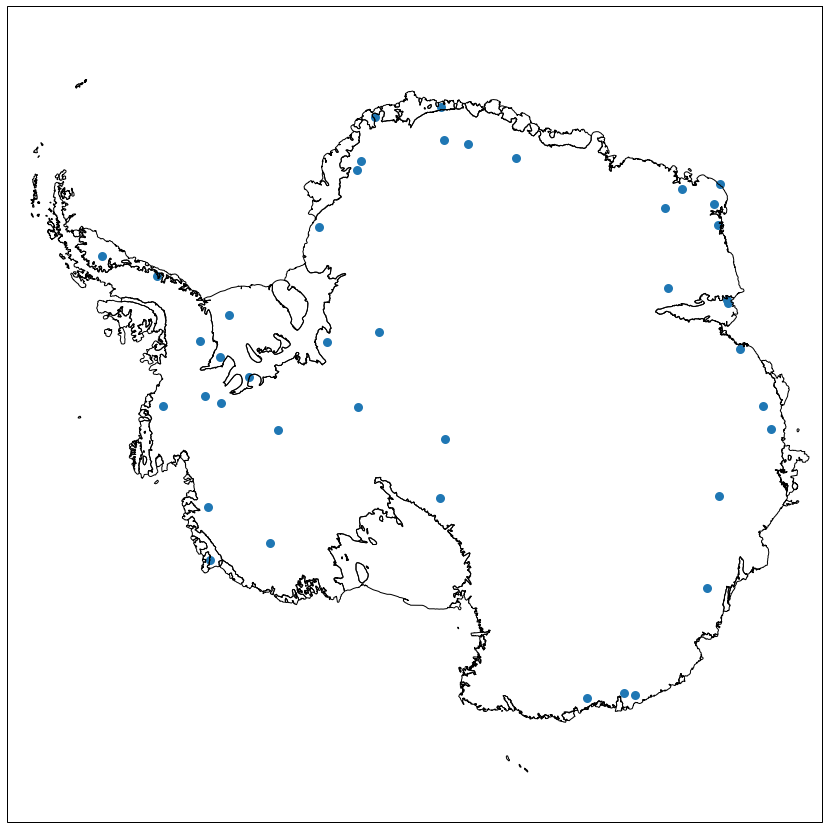

In [11]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot sites
plt.scatter(lat_lon[:,1], lat_lon[:,0], linewidth=3, transform=ccrs.PlateCarree())


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')
print(lat_lon.shape)